# DataSet Performance

This notebook shows the trade-off between inserting data into the database row-by-row and as binary blobs. Inserting the data row-by-row means that we have direct access to all the data and may perform queries directly on the values of the data. On the other hand, as we will see below, this is much slower than inserting the data directly as binary blobs

First, we choose a new location for the database to ensure that we don't add a bunch of benchmarking data to the default database.

In [1]:
import os
cwd = os.getcwd()
import qcodes as qc
qc.config["core"]["db_location"] = os.path.join(cwd, 'testing.db')


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

import qcodes as qc
from qcodes.instrument.parameter import ManualParameter
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.sqlite.database import initialise_database
from qcodes import load_or_create_experiment
from qcodes.dataset.measurements import Measurement

In [3]:
initialise_database()
exp = load_or_create_experiment(experiment_name='tutorial_exp', sample_name="no sample")

Here, we define a simple function to benchmark the time it takes to insert n points with either numeric or array data type.
We will compare both the time used to call add_result and the time used for the full measurement.

In [4]:
def insert_data(paramtype, npoints, nreps=1):

    meas = Measurement(exp=exp)

    x1 = ManualParameter('x1')
    x2 = ManualParameter('x2')
    x3 = ManualParameter('x3')
    y1 = ManualParameter('y1')
    y2 = ManualParameter('y2')

    meas.register_parameter(x1, paramtype=paramtype)
    meas.register_parameter(x2, paramtype=paramtype)
    meas.register_parameter(x3, paramtype=paramtype)
    meas.register_parameter(y1, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    meas.register_parameter(y2, setpoints=[x1, x2, x3],
                            paramtype=paramtype)
    start = time.perf_counter()
    with meas.run() as datasaver:
        start_adding = time.perf_counter()
        for i in range(nreps):
            datasaver.add_result((x1, np.random.rand(npoints)),
                                 (x2, np.random.rand(npoints)),
                                 (x3, np.random.rand(npoints)),
                                 (y1, np.random.rand(npoints)),
                                 (y2, np.random.rand(npoints)))
        stop_adding = time.perf_counter()
        run_id = datasaver.run_id
    stop = time.perf_counter()
    tot_time = stop - start
    add_time = stop_adding - start_adding
    return tot_time, add_time, run_id

## Comparison between numeric/array data and binary blob

### Case1: Short experiment time

In [5]:
sizes = [1,500,1000,2000,3000,4000,5000]
t_numeric = []
t_numeric_add = []
t_array = []
t_array_add = []
for size in sizes:
    tn, tna, run_id_n =  insert_data('numeric', size)
    t_numeric.append(tn)
    t_numeric_add.append(tna)

    ta, taa, run_id_a =  insert_data('array', size)
    t_array.append(ta)
    t_array_add.append(taa)

Starting experimental run with id: 25
Starting experimental run with id: 26
Starting experimental run with id: 27
Starting experimental run with id: 28
Starting experimental run with id: 29
Starting experimental run with id: 30
Starting experimental run with id: 31
Starting experimental run with id: 32
Starting experimental run with id: 33
Starting experimental run with id: 34
Starting experimental run with id: 35
Starting experimental run with id: 36
Starting experimental run with id: 37
Starting experimental run with id: 38


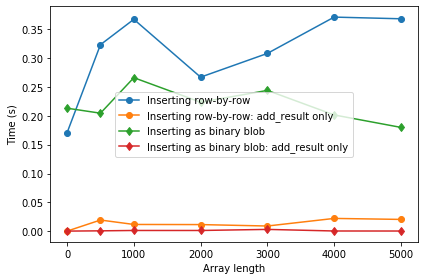

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row-by-row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row-by-row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array length')
ax.set_ylabel('Time (s)')
fig.tight_layout()

As we can see above, the time to setup and and close the experiment is approximately 0.4 sec. In case of small array sizes, the difference between inserting values of data as arrays and inserting them row-by-row is relatively unimportant. At larger array sizes i.e. above 10000 points, the cost of writing data as individual datapoints starts to become important.


### Case2: Long experiment time 

In [7]:
sizes = [1,500,1000,2000,3000,4000,5000]
nreps = 100
t_numeric = []
t_numeric_add = []
t_numeric_run_ids = []
t_array = []
t_array_add = []
t_array_run_ids = []
for size in sizes:
    tn, tna, run_id_n =  insert_data('numeric', size, nreps=nreps)
    t_numeric.append(tn)
    t_numeric_add.append(tna)
    t_numeric_run_ids.append(run_id_n)

    ta, taa, run_id_a =  insert_data('array', size, nreps=nreps)
    t_array.append(ta)
    t_array_add.append(taa)
    t_array_run_ids.append(run_id_a)

Starting experimental run with id: 39
Starting experimental run with id: 40
Starting experimental run with id: 41
Starting experimental run with id: 42
Starting experimental run with id: 43
Starting experimental run with id: 44
Starting experimental run with id: 45
Starting experimental run with id: 46
Starting experimental run with id: 47
Starting experimental run with id: 48
Starting experimental run with id: 49
Starting experimental run with id: 50
Starting experimental run with id: 51
Starting experimental run with id: 52


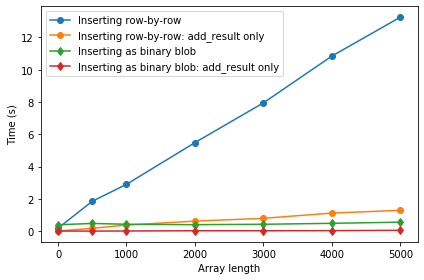

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(sizes, t_numeric, 'o-', label='Inserting row-by-row')
ax.plot(sizes, t_numeric_add, 'o-', label='Inserting row-by-row: add_result only')
ax.plot(sizes, t_array, 'd-', label='Inserting as binary blob')
ax.plot(sizes, t_array_add, 'd-', label='Inserting as binary blob: add_result only')
ax.legend()
ax.set_xlabel('Array length')
ax.set_ylabel('Time (s)')
fig.tight_layout()

However, as we increase the length of the experiment, as seen here by repeating the insertion 100 times, we see a big difference between inserting values of the data row-by-row and inserting it as a binary blob

## Loading the data 

In [9]:
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

As usual you can load the data using load_by_id but you will notice that the different storage methods
are reflected in shape of the data as it is retrieved. 

In [10]:
run_id_n = t_numeric_run_ids[0]
run_id_a = t_array_run_ids[0]

In [11]:
ds = load_by_id(run_id_n)
ds.get_data('x1')

[[0.24481607196057],
 [0.24481607196057],
 [0.35746642103054],
 [0.35746642103054],
 [0.164571972835943],
 [0.164571972835943],
 [0.680023223699177],
 [0.680023223699177],
 [0.685703110176835],
 [0.685703110176835],
 [0.60727897819078],
 [0.60727897819078],
 [0.742188166701249],
 [0.742188166701249],
 [0.154891485598477],
 [0.154891485598477],
 [0.169171345285524],
 [0.169171345285524],
 [0.0329614900464092],
 [0.0329614900464092],
 [0.785630890672504],
 [0.785630890672504],
 [0.45757942684858],
 [0.45757942684858],
 [0.905715357244874],
 [0.905715357244874],
 [0.680845680524334],
 [0.680845680524334],
 [0.55520144390634],
 [0.55520144390634],
 [0.48617079587168],
 [0.48617079587168],
 [0.166684415201401],
 [0.166684415201401],
 [0.652329455039145],
 [0.652329455039145],
 [0.685209726596538],
 [0.685209726596538],
 [0.51272758052998],
 [0.51272758052998],
 [0.596719438427337],
 [0.596719438427337],
 [0.306942439180765],
 [0.306942439180765],
 [0.714676265164774],
 [0.714676265164774],


And a dataset stored as binary arrays

In [12]:
ds = load_by_id(run_id_a)
ds.get_data('x1')

[[array([0.01349478])],
 [array([0.01349478])],
 [array([0.75950234])],
 [array([0.75950234])],
 [array([0.84781479])],
 [array([0.84781479])],
 [array([0.7745924])],
 [array([0.7745924])],
 [array([0.40645688])],
 [array([0.40645688])],
 [array([0.20272693])],
 [array([0.20272693])],
 [array([0.24294501])],
 [array([0.24294501])],
 [array([0.35235031])],
 [array([0.35235031])],
 [array([0.50350724])],
 [array([0.50350724])],
 [array([0.42424498])],
 [array([0.42424498])],
 [array([0.16717356])],
 [array([0.16717356])],
 [array([0.0855445])],
 [array([0.0855445])],
 [array([0.19451308])],
 [array([0.19451308])],
 [array([0.09730377])],
 [array([0.09730377])],
 [array([0.66777694])],
 [array([0.66777694])],
 [array([0.09730177])],
 [array([0.09730177])],
 [array([0.01310045])],
 [array([0.01310045])],
 [array([0.96469521])],
 [array([0.96469521])],
 [array([0.44896026])],
 [array([0.44896026])],
 [array([0.32039725])],
 [array([0.32039725])],
 [array([0.09507441])],
 [array([0.09507441]

This is probably more useful as a numpy array. Here we use squeze to get rid of any singleton dimensions.

In [13]:
np.array(ds.get_data('x1')).squeeze()

array([0.01349478, 0.01349478, 0.75950234, 0.75950234, 0.84781479,
       0.84781479, 0.7745924 , 0.7745924 , 0.40645688, 0.40645688,
       0.20272693, 0.20272693, 0.24294501, 0.24294501, 0.35235031,
       0.35235031, 0.50350724, 0.50350724, 0.42424498, 0.42424498,
       0.16717356, 0.16717356, 0.0855445 , 0.0855445 , 0.19451308,
       0.19451308, 0.09730377, 0.09730377, 0.66777694, 0.66777694,
       0.09730177, 0.09730177, 0.01310045, 0.01310045, 0.96469521,
       0.96469521, 0.44896026, 0.44896026, 0.32039725, 0.32039725,
       0.09507441, 0.09507441, 0.435483  , 0.435483  , 0.02235215,
       0.02235215, 0.34140035, 0.34140035, 0.40431673, 0.40431673,
       0.39366842, 0.39366842, 0.55062272, 0.55062272, 0.62758222,
       0.62758222, 0.7274949 , 0.7274949 , 0.657429  , 0.657429  ,
       0.41818034, 0.41818034, 0.43396088, 0.43396088, 0.34821455,
       0.34821455, 0.12675855, 0.12675855, 0.49727042, 0.49727042,
       0.20749588, 0.20749588, 0.48700395, 0.48700395, 0.74582

A better solution may be to use get_data_by_id which will load the data in a format that does not depend on the internal storage

In [14]:
get_data_by_id(run_id_n)

[[{'name': 'x1',
   'data': array([0.24481607, 0.35746642, 0.16457197, 0.68002322, 0.68570311,
          0.60727898, 0.74218817, 0.15489149, 0.16917135, 0.03296149,
          0.78563089, 0.45757943, 0.90571536, 0.68084568, 0.55520144,
          0.4861708 , 0.16668442, 0.65232946, 0.68520973, 0.51272758,
          0.59671944, 0.30694244, 0.71467627, 0.09063169, 0.65329602,
          0.62228264, 0.65555063, 0.40469686, 0.34866473, 0.4804782 ,
          0.35726495, 0.93977272, 0.03307416, 0.19995305, 0.96637594,
          0.05960019, 0.35756447, 0.02435593, 0.68271717, 0.66991486,
          0.41837756, 0.44805751, 0.12830128, 0.24956037, 0.29004635,
          0.64435271, 0.48654506, 0.22854538, 0.57771467, 0.73749233,
          0.80707688, 0.20435326, 0.23229841, 0.86081575, 0.03381025,
          0.44209473, 0.9162916 , 0.19021523, 0.44382743, 0.43126722,
          0.84900815, 0.71326123, 0.13159332, 0.62943662, 0.22344639,
          0.61294372, 0.2112831 , 0.87768489, 0.39131834, 0.78687

In [15]:
get_data_by_id(run_id_a)

[[{'name': 'x1',
   'data': array([0.01349478, 0.75950234, 0.84781479, 0.7745924 , 0.40645688,
          0.20272693, 0.24294501, 0.35235031, 0.50350724, 0.42424498,
          0.16717356, 0.0855445 , 0.19451308, 0.09730377, 0.66777694,
          0.09730177, 0.01310045, 0.96469521, 0.44896026, 0.32039725,
          0.09507441, 0.435483  , 0.02235215, 0.34140035, 0.40431673,
          0.39366842, 0.55062272, 0.62758222, 0.7274949 , 0.657429  ,
          0.41818034, 0.43396088, 0.34821455, 0.12675855, 0.49727042,
          0.20749588, 0.48700395, 0.74582764, 0.62357878, 0.72749412,
          0.58808788, 0.48833686, 0.37354832, 0.25154144, 0.9728355 ,
          0.05724768, 0.93010506, 0.68079653, 0.76714688, 0.57084749,
          0.379978  , 0.95726143, 0.88177402, 0.56815904, 0.54893849,
          0.16799397, 0.20551012, 0.88073766, 0.83452424, 0.42736873,
          0.22507804, 0.79450504, 0.26015142, 0.05976462, 0.32638465,
          0.95913271, 0.35596192, 0.23842327, 0.37865627, 0.77134